<a href="https://colab.research.google.com/github/Muriloozol/Corona_vizualization/blob/master/corona_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import requests as r
from bs4 import BeautifulSoup
import regex as re
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle
from matplotlib.offsetbox import DrawingArea, AnchoredOffsetbox, TextArea, VPacker, HPacker
from matplotlib.colors import LinearSegmentedColormap

# Download and clean the data


In [0]:
req = r.get('https://www.worldometers.info/coronavirus/#nav-yesterday')
soup = BeautifulSoup(req.content, 'html.parser')
table = str(soup.extract().table)
data = pd.read_html(table)[0]
data.index = data['Country,Other']
data = data.drop('Country,Other', axis=1)
data = data.drop('Total:')
cat = data['NewCases']
data['NewCases'] = [int(re.sub('\D','', cat[i])) \
                    if isinstance(cat[i],str) else np.nan\
                    for i in cat.index ]

In [0]:
data.sort_values('Tot\xa0Cases/1M pop', ascending=False).head(20)

,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop
"Country,Other",,,,,,,,,,,
San Marino,426,NaN,38.0,NaN,55.0,333,15.0,12555.0,1120.0,846.0,24933.0
Vatican City,8,NaN,NaN,NaN,2.0,6,NaN,9988.0,NaN,NaN,NaN
Andorra,682,NaN,33.0,NaN,169.0,480,17.0,8827.0,427.0,1673.0,21653.0
Luxembourg,3444,NaN,69.0,NaN,552.0,2823,35.0,5502.0,110.0,31660.0,50577.0
Iceland,1739,NaN,8.0,NaN,1144.0,587,6.0,5096.0,23.0,38204.0,111955.0
Spain,184948,NaN,19315.0,NaN,74797.0,90836,7371.0,3956.0,413.0,930230.0,19896.0
Gibraltar,131,NaN,NaN,NaN,104.0,27,1.0,3888.0,NaN,1649.0,48945.0
Faeroe Islands,184,NaN,NaN,NaN,169.0,15,NaN,3766.0,NaN,5765.0,117983.0
Isle of Man,284,NaN,4.0,NaN,154.0,126,13.0,3340.0,47.0,2261.0,26590.0


**Let's see Brazil situation compared with the rest of the world Total Cases**

In [0]:
data.loc['Brazil']

TotalCases          30683.0
NewCases                NaN
TotalDeaths          1947.0
NewDeaths               NaN
TotalRecovered      14026.0
ActiveCases         14710.0
Serious,Critical     6634.0
Tot Cases/1M pop      144.0
Deaths/1M pop           9.0
TotalTests          62985.0
Tests/ 1M pop         296.0
Name: Brazil, dtype: float64

**Split countrys on most critical corona virus situation and the others**

In [0]:
# Preparing data
try:
    brazil = data.loc['Brazil']
    data = data.drop(['Brazil', 'World'])
except KeyError:
    pass

sort = data.sort_values('TotalCases', ascending=False)

main = sort[:9]
others = sort[8:]

others_sum = others.sum()
main = main.append(brazil)

**Useful functions to make the plots**

In [0]:
def annotate_country(country_info, x, y, ax):
    s = country_info.name
    x = country_info[x]
    y = country_info[y]

    ax.annotate(s=s, xy=(x,y), 
                horizontalalignment='center',
                verticalalignment='center',
                size=12,
                weight='bold')

def basic_texts(ax, title: str, x_label: str , y_label: str):
    """
    Set the title, x and y labels for a given axe

    Parameters
    ----------
        ax: Axe object from mpl
            The axe to add the title and labels
        
        title: str
            Title to add to the respective axe

        x_label: str
            x label to add to the respective axe

        y_label: str
            y label to add to the respective axe
    
    Returns
    -------
        title: mpl.text.Text

        xlabel: mpl.text.Text

        ylabel: mpl.text.Text
    """    

    title = ax.set_title(title, fontdict={'fontsize': 20, 'weight':'heavy'})
    xlabel = ax.set_xlabel(x_label, fontdict={'fontsize': 15, 'weight': 'semibold'})
    ylabel = ax.set_ylabel(y_label, fontdict={'fontsize': 15, 'weight': 'semibold'})


    return title, xlabel, ylabel

def marker_legend(ax, sizes):

    # Define region to plot
    mk_legend = ax.inset_axes(bounds=[0.5, 0.2, 0.47, 0.2])
    mk_legend.set(xticks=[], yticks=[], facecolor='#f2f2f2')

    # Define space between the markers
    mk_x = np.cumsum(np.linspace(3, 20, 3))
    mk_y = np.zeros(3) 
    mk_s = np.linspace(500,10000, 3) 
    mk_legend.set_xlim(0, 45)
    # mk_legend.set_axis_off()
    
    # Plot the markers
    mk_sct = mk_legend.scatter(x=mk_x,
                               y=mk_y,
                               s=np.array(sizes)/5,
                               c=(0,0,0,0),
                               linewidths=1.5,
                               edgecolors=(0,0,0,0.3))

    # Write the text
    for m_x, m_y, m_s in zip(mk_x, mk_y, sizes):
        mk_legend.annotate('{:1.0f}k'.format(m_s*1e-3), (m_x,m_y),
                           horizontalalignment='center',
                           verticalalignment='center',
                           weight='semibold')
    
    # Set description
    mk_legend.set_title('Active Cases', fontdict={'weight':'semibold'})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


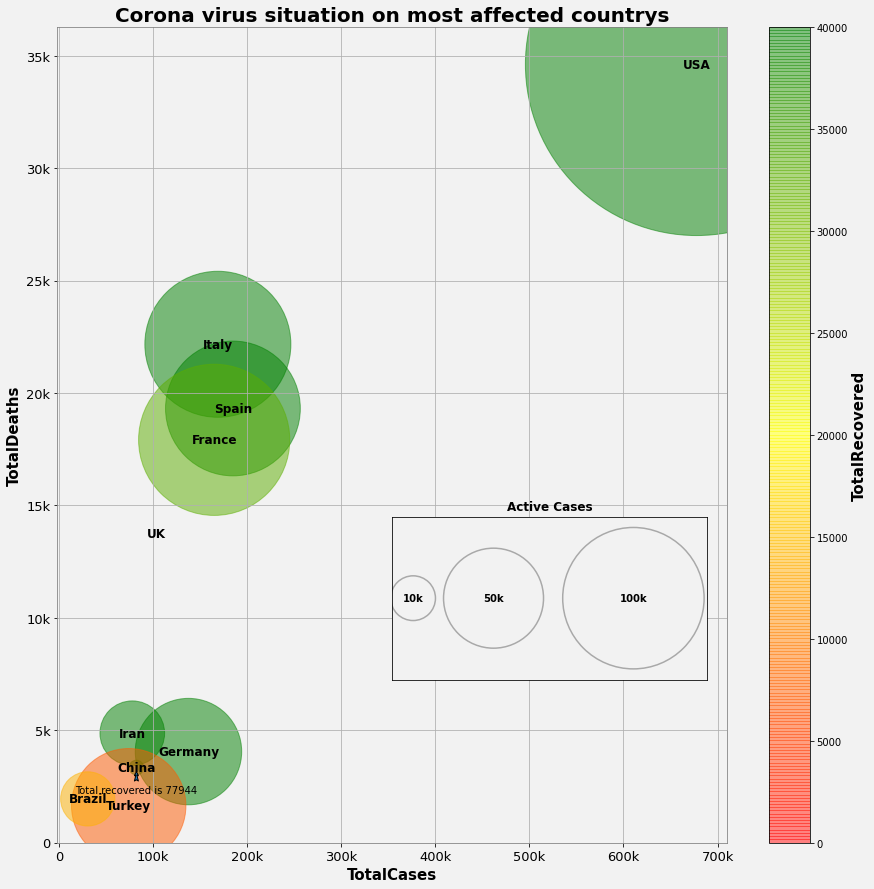

In [0]:
# Simple visualization setup
cmap = LinearSegmentedColormap.from_list('RdGn', ['Red', 'Yellow', 'Green'])
norm = mpl.colors.Normalize(vmin=0, vmax=40000)

# Defining figure and axes
fig1 = plt.figure(figsize=(15,15), facecolor='#f2f2f2')
ax1 = fig1.subplots()
ax1.set_facecolor((0.827, 0.827, 0.827, 0.3))
ax1.set_facecolor('#f2f2f2')

# Grid lines
ax1.grid(b=True)
for border in ['top', 'left', 'right', 'bottom']:
    ax1.spines[border].set(color='grey')

x = 'TotalCases'
y = 'TotalDeaths'
c = 'TotalRecovered'
s = 'ActiveCases'

# First axe
sct1 = ax1.scatter(x=main[x].values,
                   y=main[y],
                   c=main[c],
                   s=main[s]/5,
                   alpha=0.5,
                   cmap=cmap,
                   norm=norm)

# Tick labels
x_labels = [str(int(t/1000))+'k' if t!=0 else '0' for t in ax1.get_xticks()]
ax1.set_xticklabels(labels=x_labels,
                    fontdict={'fontsize':13})

y_labels = [str(int(t/1000))+'k' if t!=0 else '0' for t in ax1.get_yticks()]
ax1.set_yticklabels(labels=y_labels,
                    fontdict={'fontsize':13})

# Plot marker legend
marker_legend(ax1, sizes=[10000, 50000, 100000])

# Basic texts 
title1, xlabel1, ylabel1 = basic_texts(ax=ax1,
                                       title='Corona virus situation on most affected countrys',
                                       x_label=x,
                                       y_label=y)

# Colorbar
cbar1 = plt.colorbar(sct1, ax=ax1)
cbar1.set_label(c, fontsize=15, weight='semibold')

# Annotate China situation
# Coorditate
x_china, y_china= main.loc['China'][x], main.loc['China'][y]

# Annotation
ax1.annotate('Total recovered is {}'.format(int(main.loc['China']['TotalRecovered'])),
             xy=(x_china, y_china-100),
             horizontalalignment='center',
             verticalalignment='center',
             xytext=(x_china, y_china-1000),
             arrowprops={'arrowstyle':'fancy'})

# Put the name inside the representations
for _, country in main[:10].iterrows(): annotate_country(country, x=x, y=y, ax=ax1)
    
plt.show()